In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()

import statsmodels.graphics.tsaplots as sgt 
import statsmodels.tsa.stattools as sts 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats.distributions import chi2

In [2]:
df = pd.read_csv('./../data/weather_dataset_preprocesado.csv', index_col='datetime', parse_dates=True)
df.index = pd.to_datetime(df.index)

In [3]:
from pmdarima.arima import auto_arima
auto_arima_model = auto_arima(df['T (degC)'])
print(auto_arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                50224
Model:               SARIMAX(2, 1, 5)   Log Likelihood              -57082.607
Date:                Tue, 01 Oct 2024   AIC                         114181.214
Time:                        17:53:35   BIC                         114251.807
Sample:                    01-01-2009   HQIC                        114203.322
                         - 09-24-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9255      0.001   3535.961      0.000       1.924       1.927
ar.L2         -0.9932      0.001  -1859.318      0.000      -0.994      -0.992
ma.L1         -1.6160      0.003   -590.474      0.0

In [ ]:
auto_arima_model.predict_in_sample(n_periods=len(df)).plot()
df['T (degC)'].plot(figsize=(12,5))

<Axes: title={'center': 'Temperature Forecasting'}, xlabel='datetime'>

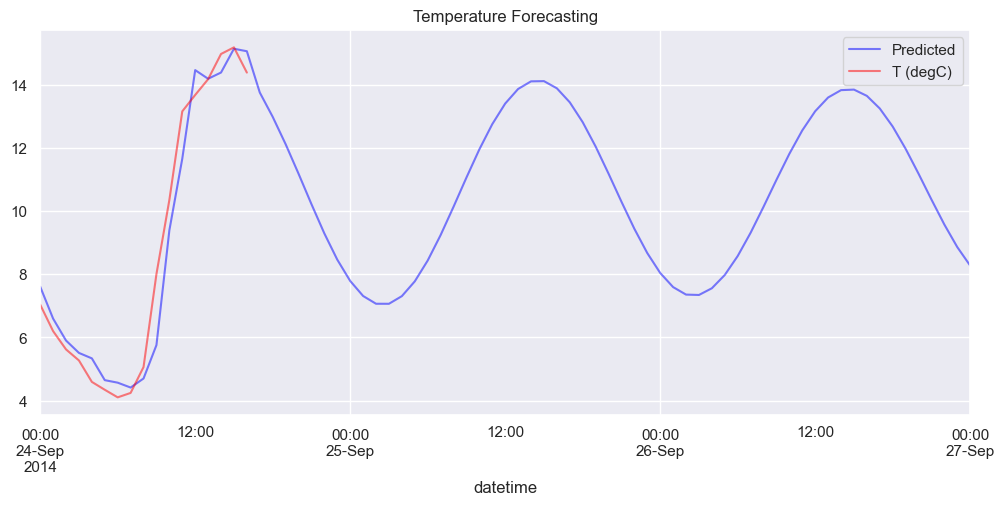

In [44]:
auto_arima_model.predict_in_sample(n_periods=len(df), 
    start='2014-09-24', 
    end='2014-09-27').plot(legend=True, color='blue', alpha=0.5, figsize=(12,5), label='Predicted', title='Temperature Forecasting')
df['T (degC)']['2014-09-24':'2014-09-27'].plot(figsize=(12,5), legend=True, color='red', alpha=0.5)

In [58]:
# Obtener predicciones y intervalos de confianza con un nivel de confianza del 80%
predictions, conf_int = auto_arima_model.predict_in_sample(n_periods=len(df), 
    start='2014-09-21', 
    end='2014-09-24', 
    freq = 'H',
    return_conf_int=True, 
    alpha=0.5)  # 80% de confianza

actual = df['T (degC)']['2014-09-21':'2014-09-24']

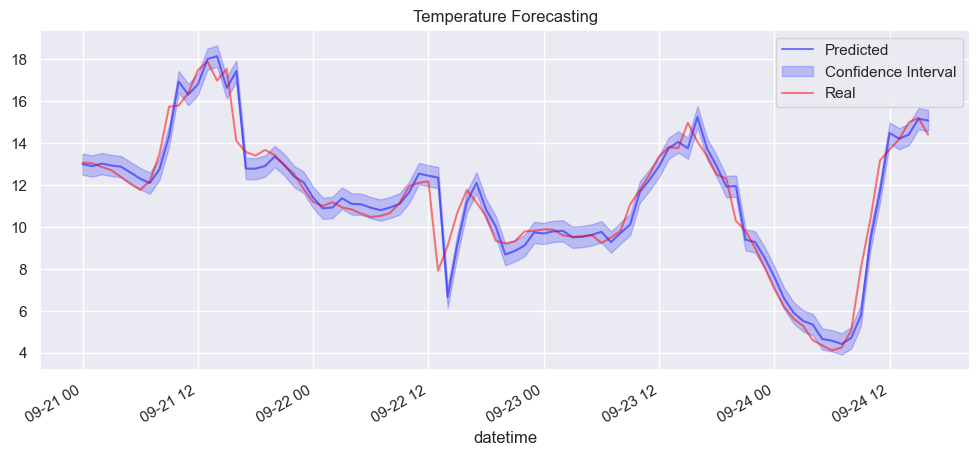

In [59]:
plt.figure(figsize=(12, 5))
plt.plot(predictions, label='Predicted', color='blue', alpha=0.5)
plt.fill_between(predictions.index, 
                 conf_int[:, 0], 
                 conf_int[:, 1], 
                 color='blue', 
                 alpha=0.2)

df['T (degC)']['2014-09-21':'2014-09-24'].plot(legend=True, color='red', alpha=0.5, label='Real')

plt.legend(['Predicted', 'Confidence Interval', 'Real'])
plt.title('Temperature Forecasting')
plt.show()

In [60]:
len(actual), len(predictions)

(89, 89)

In [62]:
mae = mean_absolute_error(actual, predictions)
mse = mean_squared_error(actual, predictions)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(actual, predictions)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

MAE: 0.5756147482233522
MSE: 0.8091467950489808
RMSE: 0.8995258723622022
MAPE: 0.05564160364541343
